Loading data from separate files...

Dataset Statistics:
Total articles: 44898
Real news: 21417 (47.7%)
Fake news: 23481 (52.3%)

Subject Distribution:
subject  Government News  Middle-east  News  US_News  left-news  politics  \
label                                                                       
0                      0            0     0        0          0         0   
1                   1570          778  9050      783       4459      6841   

subject  politicsNews  worldnews  
label                             
0               11272      10145  
1                   0          0  


<Figure size 1200x600 with 0 Axes>

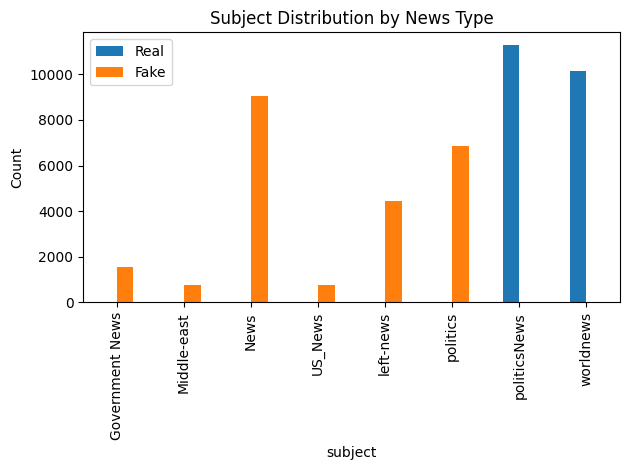


Training model using TF-IDF with Logistic Regression...
Extracting TF-IDF features...
Training Logistic Regression classifier...
Accuracy: 0.9886

Classification Report:
              precision    recall  f1-score   support

   Real-News       0.99      0.99      0.99      4270
   Fake-News       0.99      0.99      0.99      4710

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



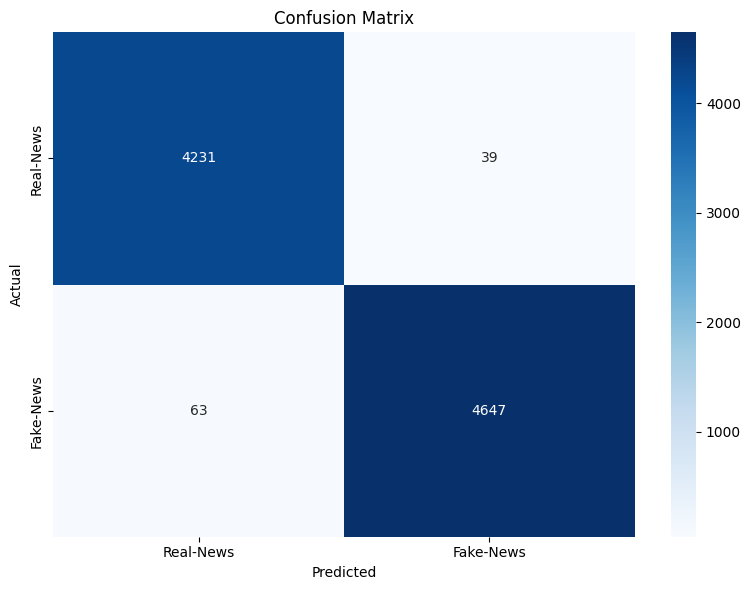


Prediction for example news:
Classification: Fake-News
Confidence: 0.98


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Function to load and preprocess the split data files
def load_split_data(fake_path, true_path):
    """
    Load data from separate Fake.csv and True.csv files and combine them
    """
    # Load the fake news data
    fake_df = pd.read_csv(fake_path)
    fake_df['label'] = 1  # 1 for fake news

    # Load the true news data
    true_df = pd.read_csv(true_path)
    true_df['label'] = 0  # 0 for real news

    # Combine the dataframes
    combined_df = pd.concat([fake_df, true_df], ignore_index=True)

    # Check for required columns and handle missing ones
    required_cols = ['text', 'title', 'subject']

    # If 'text' column doesn't exist but 'content' does, rename it
    if 'text' not in combined_df.columns and 'content' in combined_df.columns:
        combined_df.rename(columns={'content': 'text'}, inplace=True)

    # Ensure we have text content to work with
    if 'text' not in combined_df.columns:
        # If no text column, try to use title as text
        if 'title' in combined_df.columns:
            combined_df['text'] = combined_df['title']
        else:
            raise ValueError("Neither 'text' nor 'title' columns found in dataset")

    # Drop rows with missing text
    combined_df = combined_df.dropna(subset=['text'])

    # Shuffle the data
    combined_df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)

    return combined_df

# Function to build a fake news detection model using TF-IDF and Random Forest
from sklearn.linear_model import LogisticRegression

# Function to build a fake news detection model using TF-IDF and Logistic Regression
def build_fake_news_detector_with_lr(df, text_column='text', use_title=True):
    """
    Build and train a fake news detection model using TF-IDF and Logistic Regression

    Parameters:
    - df: DataFrame containing the data
    - text_column: Column name containing the article text
    - use_title: Whether to use the title along with the text
    """
    # Prepare the text data
    if use_title and 'title' in df.columns:
        # Combine title and text if both are available
        X = df.apply(lambda row: row['title'] + " " + str(row[text_column]) if pd.notnull(row['title']) else str(row[text_column]), axis=1)
    else:
        X = df[text_column]

    y = df['label']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Create TF-IDF features
    print("Extracting TF-IDF features...")
    tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), stop_words='english')
    X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
    X_test_tfidf = tfidf_vectorizer.transform(X_test)

    # Train a Logistic Regression model
    print("Training Logistic Regression classifier...")
    model = LogisticRegression(max_iter=1000, random_state=42)
    model.fit(X_train_tfidf, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test_tfidf)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")

    # Display classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Real-News', 'Fake-News']))

    # Create confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Real-News', 'Fake-News'],
                yticklabels=['Real-News', 'Fake-News'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

    return model, tfidf_vectorizer

# Function to print top features based on Random Forest feature importances
def print_top_features(model, vectorizer, n=20):
    """Print the top N important features from Random Forest model"""
    feature_names = vectorizer.get_feature_names_out()

    # Get feature importances
    importances = model.feature_importances_

    # Sort indices by importance values
    indices = np.argsort(importances)[-n:][::-1]

    print("\nTop features for news classification:")
    for idx in indices:
        print(f"{feature_names[idx]}: {importances[idx]:.6f}")

# Function to predict whether a news article is fake or real
def predict_news(model, vectorizer, news_text, news_title=None):
    """
    Predict whether a news article is fake or real
    """
    # Combine title and text if title is provided
    if news_title:
        full_text = news_title + " " + news_text
    else:
        full_text = news_text

    # Transform the news text using the TF-IDF vectorizer
    news_tfidf = vectorizer.transform([full_text])

    # Make prediction
    prediction = model.predict(news_tfidf)[0]
    probability = model.predict_proba(news_tfidf)[0]

    # Return results
    result = {
        'is_fake': bool(prediction),
        'prediction': 'Fake-News' if prediction == 1 else 'Real-News',
        'confidence': probability[prediction],
    }

    return result

# Function to analyze dataset statistics
def analyze_dataset(df):
    """Print dataset statistics"""
    print("\nDataset Statistics:")
    print(f"Total articles: {len(df)}")
    print(f"Real news: {sum(df['label'] == 0)} ({sum(df['label'] == 0)/len(df)*100:.1f}%)")
    print(f"Fake news: {sum(df['label'] == 1)} ({sum(df['label'] == 1)/len(df)*100:.1f}%)")

    if 'subject' in df.columns:
        print("\nSubject Distribution:")
        subject_counts = df.groupby(['label', 'subject']).size().unstack(fill_value=0)
        print(subject_counts)

        # Plot subject distribution
        plt.figure(figsize=(12, 6))
        df_real = df[df['label'] == 0]['subject'].value_counts()
        df_fake = df[df['label'] == 1]['subject'].value_counts()

        combined = pd.DataFrame({'Real': df_real, 'Fake': df_fake}).fillna(0)
        combined.plot(kind='bar')
        plt.title('Subject Distribution by News Type')
        plt.ylabel('Count')
        plt.tight_layout()
        plt.show()

# Example usage of the modified code:
if __name__ == "__main__":
    fake_path = "/Fake.csv"
    true_path = "/True.csv"

    try:
        # Load and combine the data
        print("Loading data from separate files...")
        df = load_split_data(fake_path, true_path)

        # Analyze dataset
        analyze_dataset(df)

        # Build and train the model using Logistic Regression
        print("\nTraining model using TF-IDF with Logistic Regression...")
        model, vectorizer = build_fake_news_detector_with_lr(df)

        # Example prediction
        example_title = "Breaking: Shocking discovery reveals hidden truth"
        example_news = """
        In a stunning development that experts are calling unprecedented,
        new evidence has emerged that contradicts everything we thought we knew.
        Anonymous sources close to the investigation have revealed shocking details
        that could change the course of history. Many people are saying this is
        the biggest scandal of our time.
        """

        result = predict_news(model, vectorizer, example_news, example_title)
        print("\nPrediction for example news:")
        print(f"Classification: {result['prediction']}")
        print(f"Confidence: {result['confidence']:.2f}")

    except FileNotFoundError as e:
        print(f"Error: {e}")
        print("\nPlease check your file paths:")
        print(f"Fake news path: {fake_path}")
        print(f"True news path: {true_path}")
    except Exception as e:
        print(f"An error occurred: {e}")

In [3]:
import joblib

def save_model_and_vectorizer(model, vectorizer, model_path="fake_news_model.pkl", vec_path="tfidf_vectorizer.pkl"):
    joblib.dump(model, model_path)
    joblib.dump(vectorizer, vec_path)
    print(f"Model saved to {model_path}")
    print(f"Vectorizer saved to {vec_path}")

save_model_and_vectorizer(model, vectorizer)


Model saved to fake_news_model.pkl
Vectorizer saved to tfidf_vectorizer.pkl
